# **ML Assignment 3**

**Goal:** Predict whether a customer will subscribe to a term deposit (yes / no)

**Model:** Logistic Regression (Binary Classification)

**Why not only accuracy?**

False Positives → marketing cost wasted

False Negatives → lost potential customer
→ Hence Precision, Recall, F1, ROC, Sensitivity, Specificity

In [54]:
import pandas as pd
import numpy as np

In [1]:
pip install ucimlrepo

In [18]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [19]:
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [20]:
df = pd.concat([X, y], axis=1)

In [22]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [23]:
df.rename(columns={'y': 'subscribed'}, inplace=True)

In [24]:
print("Shape:", df.shape)
print("\nTarget distribution:")
print(df['subscribed'].value_counts())
print("\nTarget distribution (%):")
print(df['subscribed'].value_counts(normalize=True) * 100)

Shape: (45211, 17)

Target distribution:
subscribed
no     39922
yes     5289
Name: count, dtype: int64

Target distribution (%):
subscribed
no     88.30152
yes    11.69848
Name: proportion, dtype: float64


- **Dataset is imbalanced (~11–12% “yes”)**
- **Accuracy alone would be misleading → need ROC, Recall, F1**

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  subscribed   45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [26]:
df.isnull().sum()

,0
age,0
job,288
marital,0
education,1857
default,0
balance,0
housing,0
loan,0
contact,13020
day_of_week,0


## **Handling Missing Values**

**Observations from data:** job, education, contact, poutcome have missing values. These are categorical, not numerical

**Strategy (industry-standard):** Replace missing categorical values with "**unknown**"

In [27]:
categorical_cols = df.select_dtypes(include='object').columns

df[categorical_cols] = df[categorical_cols].fillna("unknown")

In [28]:
# Encode Target Variable
df['subscribed'] = df['subscribed'].map({'yes': 1, 'no': 0})

### **Age vs Subscription**

In [29]:
df.groupby('subscribed')['age'].mean()

,age
subscribed,
0,40.838986
1,41.670070


Subscribers tend to be slightly older → stable income

### **Balance vs Subscription**

In [31]:
df.groupby('subscribed')['balance'].median()

,balance
subscribed,
0,417.0
1,733.0


Higher balance customers more likely to subscribe

Balance is a strong predictor

### **Subscription Rate by Job**

In [32]:
job_sub_rate = (df.groupby('job')['subscribed'].mean().sort_values(ascending=False))
print(job_sub_rate)

job
student          0.286780
retired          0.227915
unemployed       0.155027
management       0.137556
admin.           0.122027
self-employed    0.118429
unknown          0.118056
technician       0.110570
services         0.088830
housemaid        0.087903
entrepreneur     0.082717
blue-collar      0.072750
Name: subscribed, dtype: float64


retired, student, unemployed → higher subscription

blue-collar → lower subscription

### **Subscription Rate by Education**

In [33]:
edu_sub_rate = (df.groupby('education')['subscribed'].mean().sort_values(ascending=False))
print(edu_sub_rate)

education
tertiary     0.150064
unknown      0.135703
secondary    0.105594
primary      0.086265
Name: subscribed, dtype: float64


Higher education → better financial awareness

### **Housing Loan Impact**

In [34]:
df.groupby('housing')['subscribed'].mean()

,subscribed
housing,
no,0.167024
yes,0.077000


Customers without housing loans subscribe more

Loan burden affects investment decisions

### **Contact Method Effectiveness**

In [36]:
df.groupby('contact')['subscribed'].mean()

,subscribed
contact,
cellular,0.149189
telephone,0.134205
unknown,0.040707


Cellular contact is more effective than unknown/telephone

### **Duration**

In [37]:
df.groupby('subscribed')['duration'].mean()

,duration
subscribed,
0,221.182806
1,537.294574


Longer call duration → higher chance of subscription

Strong predictor but post-call feature

This is a limitation in real deployment

### **Number of Contacts**

In [38]:
df.groupby('subscribed')['campaign'].mean()

,campaign
subscribed,
0,2.846350
1,2.141047


Too many contacts → lower success

Over-marketing annoys customers

### **Correlation Analysis**

In [40]:
numerical_features = X.select_dtypes(include=['int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [41]:
corr = df[numerical_features.tolist() + ['subscribed']].corr()
print(corr['subscribed'].sort_values(ascending=False))

subscribed     1.000000
duration       0.394521
pdays          0.103621
previous       0.093236
balance        0.052838
age            0.025155
day_of_week   -0.028348
campaign      -0.073172
Name: subscribed, dtype: float64


### **Key Takeaways**
- Dataset is **imbalanced**
- Call duration is strongest predictor
- Customers with:
  - Higher balance
  - Higher education
  - Fewer campaign contacts are more **likely to subscribe**
- Certain features (duration) are not available before the call → model realism issue

### **Split Features and Target**

In [42]:
X = df.drop(columns=['subscribed'])
y = df['subscribed']

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### **Train-Test Split**

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

### **Build Logistic Regression Pipeline**

In [46]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [47]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

### **Predict Probabilities**

In [48]:
y_prob = model.predict_proba(X_test)[:, 1]

### **Predictions at Threshold = 0.5**

In [49]:
threshold_1 = 0.5
y_pred_05 = (y_prob >= threshold_1).astype(int)

### **Evaluation Metrics**

In [51]:
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

cm = confusion_matrix(y_test, y_pred_05)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[9723  258]
 [ 857  465]]


In [52]:
precision = precision_score(y_test, y_pred_05)
recall = recall_score(y_test, y_pred_05)      # Sensitivity
f1 = f1_score(y_test, y_pred_05)
specificity = tn / (tn + fp)

roc_auc = roc_auc_score(y_test, y_prob)

print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)

Precision: 0.6431535269709544
Recall (Sensitivity): 0.3517397881996974
Specificity: 0.974150886684701
F1-score: 0.4547677261613692
ROC-AUC: 0.906139971543512


### **Threshold Optimization (Second Threshold)**

In [55]:
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1 = 0
best_threshold = 0

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    f1_t = f1_score(y_test, y_pred_t)

    if f1_t > best_f1:
        best_f1 = f1_t
        best_threshold = t

print("Best Threshold:", best_threshold)
print("Best F1:", best_f1)

Best Threshold: 0.21999999999999995
Best F1: 0.5841550493029581


### **Metrics at Optimized Threshold**

In [56]:
y_pred_opt = (y_prob >= best_threshold).astype(int)

cm_opt = confusion_matrix(y_test, y_pred_opt)
tn, fp, fn, tp = cm_opt.ravel()

print("Optimized Confusion Matrix:\n", cm_opt)

print("Precision:", precision_score(y_test, y_pred_opt))
print("Recall:", recall_score(y_test, y_pred_opt))
print("Specificity:", tn / (tn + fp))
print("F1-score:", f1_score(y_test, y_pred_opt))

Optimized Confusion Matrix:
 [[9221  760]
 [ 463  859]]
Precision: 0.5305744286596664
Recall: 0.6497730711043873
Specificity: 0.9238553251177237
F1-score: 0.5841550493029581


### **ROC-Curve Plot**

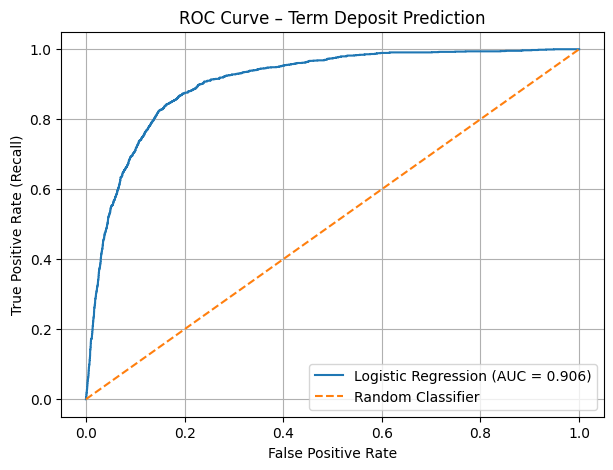

In [58]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve – Term Deposit Prediction')
plt.legend()
plt.grid()
plt.show()

In [57]:
output_df = pd.DataFrame({
    "RecordId": X_test.index,
    "Probability(yes)": y_prob,
    "PredictedLabel": y_pred_opt
})

output_df.to_csv("probabilities.csv", index=False)